In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=

In [0]:
!ls

adc.json  drive  sample_data


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls

In [0]:
import os
os.chdir("drive/Colab Notebooks") 

In [0]:
!ls

 239_CNN_By_person.ipynb   EEG_loading.ipynb
 239_CNN_sc_person.ipynb   person_test.npy
 239_shallow.ipynb	   person_train_valid.npy
 cnn_Vanilla.ipynb	   results
 cs260_FC.ipynb		  'RNN_project_slidingW(1) (1).ipynb'
 cs260_hw3_CNN.ipynb	   X_test.npy
 cs260.ipynb		   X_train_valid.npy
 ee239_500epoch.ipynb	   y_test.npy
 ee239.ipynb		   y_train_valid.npy
 ee239_new_lenet.ipynb


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms


def flatten(x):
    """
    Input:
    - Tensor of shape (N, D1, ..., DM)
    Output:
    - Tensor of shape (N, D1 * ... * DM)
    """
    x_shape = x.size()
    new_shape = 1
    for i in range(len(x_shape) - 1):
        new_shape *= x_shape[i + 1]
    x_flat = x.reshape((x_shape[0],new_shape))
    return x_flat


############################################################################
#                                Architecture                              #
############################################################################

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=(1, 40)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(30),
        )
        self.block2 = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=(5, 22, 1)),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.block3 = nn.Sequential(
            nn.AvgPool2d(kernel_size=(1, 50)),
        )
        self.block4 = nn.Sequential(
            torch.nn.Linear(26*19,1),
            nn.Softmax(dim=1),
        )

    def forward(self, x, viz=False):
        N, _, _, _ = x.size()
        x = self.block1(x)
        x = x.unsqueeze(1)
        x = self.block2(x)
        x = x.squeeze()
        x = self.block3(x)
        x = x.view(N,4,-1)
        x = self.block4(x)
        return flatten(x)


############################################################################
#                             Hyper parameters                             #
############################################################################
epochs = 40
batch_size = 64 


seed = 12345
device = 0
path = './results/model/'
log = './results/log/'

cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.set_device(device)
    torch.cuda.manual_seed(seed)




X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


X_train = X_train_valid.reshape((2115, 1, 25, 1000))
X_test = X_test.reshape((443, 1, 25, 1000))




trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train[:,:,:22,:]).float(), torch.from_numpy(y_train_valid - 769).long())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

model = LeNet()
# if torch.cuda.is_available():
#     model = model.cuda()
if cuda:
    model = model.cuda()

############################################################################
#                                Optimization                              #
############################################################################
lr = 1e-3
#lr = 1e-3
#weight_decay=1e-3
#weight_decay = 1e-5
#betas=(0.9,0.99)
betas = (0.9, 0.999)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

if not os.path.exists(path):
    os.makedirs(path)
if not os.path.exists(log):
    os.makedirs(log)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
valid_loss=[]
valid_acc=[]


def save_model(state, path):
    torch.save(state, os.path.join(path))


def train(epoch):
    model.train()
    training_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (x, y) in enumerate(trainloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    train_loss.append(training_loss/len(trainloader))
    train_acc.append(100.*correct/total)
    print('Training Epoch:{}, Training Loss:{:.6f}, Acc:{:6f}'.format(epoch, training_loss/len(trainloader), 100.*correct/total))

def test(epoch):
    model.eval()
    testing_loss = 0
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(testloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        output = model(x)
        loss = criterion(output, y)
        
        testing_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    test_loss.append(testing_loss/len(testloader))
    test_acc.append(100.*correct/total)
    print('Testing Epoch:{}, Testing Loss:{:.6f}, Acc:{:6f}.'.format(epoch, testing_loss/len(testloader), 100.*correct/total))

def valid(epoch):
    model.eval()
    validing_loss = 0
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(validloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        output = model(x)
        loss = criterion(output, y)
        
        validing_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    valid_loss.append(validing_loss/len(validloader))
    valid_acc.append(100.*correct/total)
    print('Validing Epoch:{}, Valid Loss:{:.6f}, Acc:{:6f}.'.format(epoch, validing_loss/len(validloader), 100.*correct/total))
    
    
def plot_loss(train_loss, test_loss):
    plt.plot(valid_loss, label = "valid")
    plt.plot(train_loss, label = "train")
    plt.xlabel("eopch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("The loss against epoch")
    plt.show()


def plot_acc(train_acc, test_acc):
    plt.plot(valid_acc, label = "valid")
    plt.plot(train_acc, label = "train")
    plt.xlabel("eopch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("The accuracy against epoch")
    plt.show()

  

In [0]:



x_test_list=[[] for i in range(9)]
y_test_list=[[] for i in range(9)]
for i in range(len(person_test)):
#   np.append(x_test_list[int(person_test[i][0])],X_test[i])
#   np.append(y_test_list[int(person_test[i][0])],y_test[i])
  x_test_list[int(person_test[i][0])].append(X_test[i])
  y_test_list[int(person_test[i][0])].append(y_test[i])
x_test_08=np.array(x_test_list)
y_test_08=np.array(y_test_list)
print(len(x_test_08[6]))
print(len(y_test_08[6]))
# print(x_test_08.shape)
print(X_train[:,:,:22,:].shape)

50
50
(2115, 1, 22, 1000)


In [0]:
def train(epoch):
    model.train()
    training_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (x, y) in enumerate(trainloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    train_loss.append(training_loss/len(trainloader))
    train_acc.append(100.*correct/total)
    print('Training Epoch:{}, Training Loss:{:.6f}, Acc:{:6f}'.format(epoch, training_loss/len(trainloader), 100.*correct/total))

def test_people(subject):
    model.eval()
    testing_loss = 0
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(testloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        output = model(x)
        loss = criterion(output, y)
        
        testing_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    #test_loss.append(testing_loss/len(testloader))
    #test_acc.append(100.*correct/total)
    print('people:{}, Testing Loss:{:.6f}, Acc:{:6f}.'.format(subject+1, testing_loss/len(testloader), 100.*correct/total))


In [0]:
X_train_valid = X_train_valid.reshape((2115, 1, 25, 1000))
X_test = X_test.reshape((443, 1, 25, 1000))

index = np.arange(2115)
np.random.shuffle(index)
training_index, valid_index = index[:1715], index[1715:]
print(X_train_valid.shape)
X_train_valid = X_train_valid[:,:, :22, :]
X_train = X_train_valid[training_index]
X_valid = X_train_valid[valid_index]
X_test = X_test[:,:, :22, :]

y_train = y_train_valid[training_index]
y_valid = y_train_valid[valid_index]


trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train - 769).long())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = torch.utils.data.TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid - 769).long())
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

(2115, 1, 25, 1000)


Training Epoch:0, Training Loss:1.385731, Acc:28.513120
Validing Epoch:0, Valid Loss:1.384097, Acc:33.500000.
Testing Epoch:0, Testing Loss:1.384975, Acc:29.571106.
Training Epoch:1, Training Loss:1.381485, Acc:32.653061
Validing Epoch:1, Valid Loss:1.374883, Acc:35.500000.
Testing Epoch:1, Testing Loss:1.380532, Acc:29.345372.
Training Epoch:2, Training Loss:1.365719, Acc:32.944606
Validing Epoch:2, Valid Loss:1.356024, Acc:34.750000.
Testing Epoch:2, Testing Loss:1.370685, Acc:32.279910.
Training Epoch:3, Training Loss:1.345472, Acc:36.443149
Validing Epoch:3, Valid Loss:1.336952, Acc:38.250000.
Testing Epoch:3, Testing Loss:1.351737, Acc:34.085779.
Training Epoch:4, Training Loss:1.326700, Acc:38.542274
Validing Epoch:4, Valid Loss:1.325143, Acc:38.250000.
Testing Epoch:4, Testing Loss:1.342496, Acc:36.117381.
Training Epoch:5, Training Loss:1.309204, Acc:41.166181
Validing Epoch:5, Valid Loss:1.313024, Acc:40.000000.
Testing Epoch:5, Testing Loss:1.324214, Acc:37.697517.
Training E

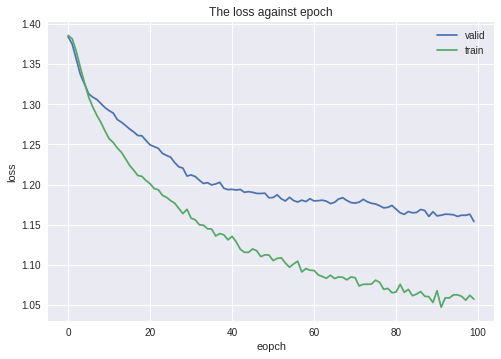

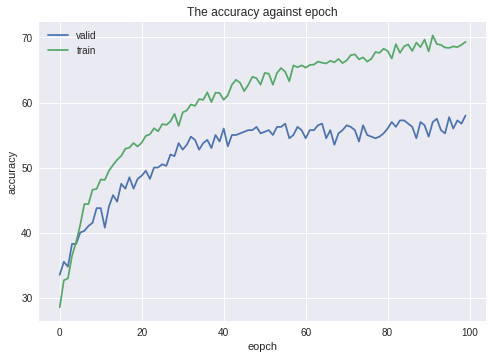

[29.571106094808126, 29.345372460496613, 32.27990970654628, 34.08577878103837, 36.11738148984199, 37.69751693002257, 38.1489841986456, 39.05191873589165, 39.503386004514674, 38.37471783295711, 38.82618510158014, 38.82618510158014, 39.9548532731377, 40.63205417607224, 40.85778781038375, 42.21218961625282, 41.98645598194131, 44.01805869074492, 46.27539503386004, 44.92099322799097, 46.50112866817156, 46.95259593679458, 48.53273137697517, 47.855530474040634, 47.40406320541761, 48.081264108352144, 49.66139954853273, 49.887133182844245, 50.33860045146727, 50.56433408577878, 52.8216704288939, 50.56433408577878, 53.72460496613996, 52.144469525959366, 53.04740406320542, 53.72460496613996, 53.72460496613996, 53.04740406320542, 54.401805869074494, 53.49887133182844, 54.853273137697514, 54.17607223476298, 55.53047404063206, 53.95033860045147, 54.853273137697514, 55.98194130925508, 55.30474040632054, 55.98194130925508, 55.98194130925508, 54.853273137697514, 54.853273137697514, 55.98194130925508, 56

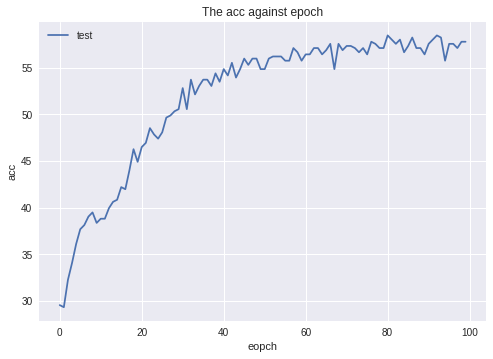

In [0]:

for i in range(100):
  train(i)
  valid(i)
  test(i)
  

#   if i%10==0:
#     print("#############################")
#     for i in range(9):
#       testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_08[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_08[i]) - 769).long())
#       testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
#       test_people(i)
#     testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
#     testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
#     test_people(-1)
#    print("#############################")
plot_loss(train_loss, valid_loss)
plot_acc(train_acc, valid_acc)
print(test_acc)
plt.plot(test_acc, label = "test")
plt.xlabel("eopch")
plt.ylabel("acc")
plt.legend()
plt.title("The acc against epoch")
plt.show()

Training Epoch:0, Training Loss:1.383774, Acc:27.470449
Testing Epoch:0, Testing Loss:1.379884, Acc:30.699774.
#############################
people:1, Testing Loss:1.372645, Acc:32.000000.
people:2, Testing Loss:1.384559, Acc:30.000000.
people:3, Testing Loss:1.379782, Acc:28.000000.
people:4, Testing Loss:1.379446, Acc:28.000000.
people:5, Testing Loss:1.383678, Acc:27.659574.
people:6, Testing Loss:1.382125, Acc:30.612245.
people:7, Testing Loss:1.376000, Acc:36.000000.
people:8, Testing Loss:1.380040, Acc:36.000000.
people:9, Testing Loss:1.380602, Acc:27.659574.
people:0, Testing Loss:1.379884, Acc:30.699774.
#############################
Training Epoch:1, Training Loss:1.372039, Acc:31.867612
Testing Epoch:1, Testing Loss:1.362628, Acc:33.860045.
Training Epoch:2, Training Loss:1.352160, Acc:35.555556
Testing Epoch:2, Testing Loss:1.347196, Acc:32.505643.
Training Epoch:3, Training Loss:1.326280, Acc:38.108747
Testing Epoch:3, Testing Loss:1.334083, Acc:36.117381.
Training Epoch:4

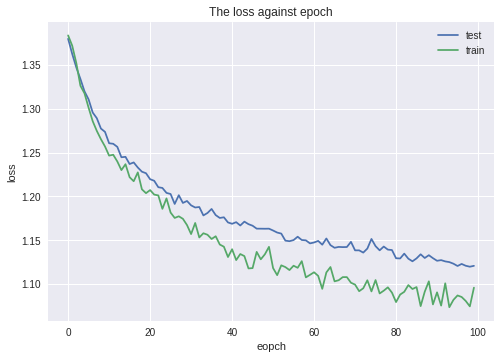

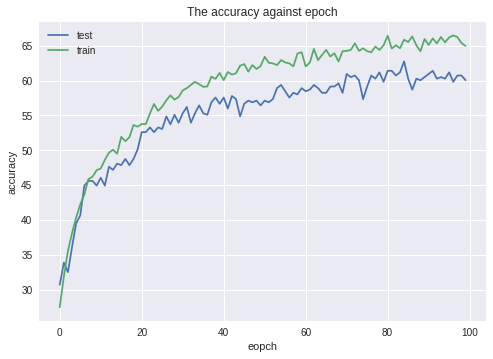

In [0]:
for i in range(100):
  train(i)
  valid(i)
  test(i)
  

  if i%10==0:
    print("#############################")
    for i in range(9):
      testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_08[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_08[i]) - 769).long())
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
      test_people(i)
    testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_people(-1)
    print("#############################")
  if train_acc[-1]>95:
    break
plot_loss(train_loss, test_loss)
plot_acc(train_acc, test_acc)

In [0]:
for i in range(9):
  testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_08[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_08[i]) - 769).long())
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_people(i)
testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_people(-1)

people:1, Testing Loss:1.103096, Acc:66.000000.
people:2, Testing Loss:1.271337, Acc:44.000000.
people:3, Testing Loss:1.057103, Acc:70.000000.
people:4, Testing Loss:1.131649, Acc:60.000000.
people:5, Testing Loss:1.144608, Acc:57.446809.
people:6, Testing Loss:1.246850, Acc:46.938776.
people:7, Testing Loss:1.159205, Acc:54.000000.
people:8, Testing Loss:1.171867, Acc:56.000000.
people:9, Testing Loss:1.083923, Acc:65.957447.
people:0, Testing Loss:1.152033, Acc:57.787810.


In [0]:
x_test_list_class=[[] for i in range(4)]
y_test_list_class=[[] for i in range(4)]
for i in range(len(y_test)):
  x_test_list_class[int(y_test[i])-769].append(X_test[i])
  y_test_list_class[int(y_test[i])-769].append(y_test[i])

x_test_class=np.array(x_test_list_class)
y_test_class=np.array(y_test_list_class)

train_acc = []
print(y_test_list_class)

[[769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769], [770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 7

In [0]:
# trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train[:,:,:22,:]).float(), torch.from_numpy(y_train_valid - 769).long())
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

for i in range(4):
  testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_class[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_class[i]) - 769).long())
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_people(i)
testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_people(-1)


people:1, Testing Loss:1.187114, Acc:55.855856.
people:2, Testing Loss:1.187308, Acc:52.755906.
people:3, Testing Loss:1.100932, Acc:64.583333.
people:4, Testing Loss:1.130993, Acc:59.633028.
people:0, Testing Loss:1.152033, Acc:57.787810.
